In [1]:
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
import pandas as pd
import re
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn import metrics, datasets
from sklearn.utils import shuffle
#nltk.download('stopwords')

In [2]:
def get_words(filename):
    words = []
    counts = []
    
    with open(filename, mode='r', encoding="utf-8") as f:
        for line in f:
            # check for comments
            if line.startswith('#'):
                continue
            elif line.startswith('T'):
                split = line.strip().split(',')
                counts.append(split)
            else:
                split = line.strip(' %\n').split(',')
                words.append(split)

    return words[0], counts

In [3]:
# Requires downloading the test/train files from http://millionsongdataset.com/musixmatch/#getting
MXM_DATASET_TEST = 'mxm_dataset_test.txt'
MXM_DATASET_TRAIN = 'mxm_dataset_train.txt'
words, counts_train = get_words(MXM_DATASET_TRAIN)
words, counts_test = get_words(MXM_DATASET_TEST)

counts = counts_train + counts_test

In [4]:
p = re.compile('(\d*):(\d*)')
rows = len(counts)
indexed_counts = np.zeros((rows, 5000), dtype='int')
msd_id = []
mxm_id = []

for i in range(rows):
    for item in counts[i]:
        if item == counts[i][0]:
            msd_id.append(item)
        elif item == counts[i][1]:
            mxm_id.append(item)
        else:
            m = p.match(item)
            index = int(m.group(1))
            count = m.group(2)
            indexed_counts[i][index-1] = count

In [5]:
word_index = range(1, 5001, 1)
df_msd = pd.DataFrame(msd_id, columns = ['msd_id'])
df_counts = pd.DataFrame(indexed_counts, columns = words)

In [6]:
combo = pd.concat([df_msd, df_counts], axis=1)
combo.head()

,msd_id,i,the,you,to,and,a,me,it,not,...,writer,motivo,bake,insist,wel,santo,pe,gee,colleg,kad
0,TRAAAAV128F421A322,6,4,2,2,5,3,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,TRAAABD128F429CF47,10,0,17,8,2,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0
2,TRAAAED128E0783FAB,28,15,2,12,22,2,2,4,2,...,0,0,0,0,0,0,0,0,0,0
3,TRAAAEF128F4273421,5,4,3,2,1,11,0,0,4,...,0,0,0,0,0,0,0,0,0,0
4,TRAAAEW128F42930C0,4,0,0,5,7,2,4,0,1,...,0,0,0,0,0,0,0,0,0,0


In [7]:
country = pd.read_csv("data/country.csv", names=['msd_id', 'track_name', 'track_artist'])
pop = pd.read_csv("data/pop.csv", names=['msd_id', 'track_name', 'track_artist'])
rnb = pd.read_csv("data/rnb.csv", names=['msd_id', 'track_name', 'track_artist'])
rock = pd.read_csv("data/rock.csv", names=['msd_id', 'track_name', 'track_artist'])

country['genre'] = 'country'
pop['genre'] = 'pop'
rnb['genre'] = 'rnb'
rock['genre'] = 'rock'

country = country.drop(['track_name', 'track_artist'], axis=1)
pop = pop.drop(['track_name', 'track_artist'], axis=1)
rnb = rnb.drop(['track_name', 'track_artist'], axis=1)
rock = rock.drop(['track_name', 'track_artist'], axis=1)

total = country
total = total.append(pop).append(rnb).append(rock)

In [8]:
s1 = pd.merge(combo, total, how='inner', on=['msd_id'])
s1 = s1.drop(['msd_id'], axis=1)
s1.head()

,i,the,you,to,and,a,me,it,not,in,...,motivo,bake,insist,wel,santo,pe,gee,colleg,kad,genre
0,5,4,3,2,1,11,0,0,4,0,...,0,0,0,0,0,0,0,0,0,rock
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pop
2,6,7,3,1,15,10,1,13,1,3,...,0,0,0,0,0,0,0,0,0,rock
3,5,3,3,3,8,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
4,11,5,6,3,10,6,6,7,1,3,...,0,0,1,0,0,0,0,0,0,rock


In [9]:
s3 = pd.DataFrame(s1[[w for w in words if w not in stopwords.words("english")]]).to_dict(orient='records')
y = pd.DataFrame(s1['genre']).to_numpy().tolist()

new_list = []
for i, label in enumerate(y):
    new_list.append((s3[i], label[0]))

divider = int(len(new_list) * 0.8)

train_set, test_set = [new_list[:divider], new_list[divider:]]
classif = nltk.NaiveBayesClassifier.train(train_set)

In [10]:
def show_most_informative_features_in_list(classifier, n=10):
    """
    Return a nested list of the "most informative" features 
    used by the classifier along with it's predominant labels
    """
    cpdist = classifier._feature_probdist       # probability distribution for feature values given labels
    feature_list = []
    for (fname, fval) in classifier.most_informative_features(n):
        def labelprob(l):
            return cpdist[l, fname].prob(fval)
        labels = sorted([l for l in classifier._labels if fval in cpdist[l, fname].samples()], 
                        key=labelprob)
        feature_list.append([fname, labels[-1]])
    return feature_list

In [11]:
features = show_most_informative_features_in_list(classif, 4884)

pop_words = []
rnb_words = []
rock_words = []
country_words = []

for (word, label) in features:
    if label == 'pop':
        pop_words.append(word)
    if label == 'rnb':
        rnb_words.append(word)
    if label == 'rock':
        rock_words.append(word)
    if label == 'country':
        country_words.append(word)

least_imp = pop_words[:] + rock_words[:]

In [12]:
for stopword in stopwords.words("english"):
    if stopword in words:
        s1 = s1.drop([stopword], axis=1, errors='ignore')
s1.head()

,love,know,like,que,time,come,de,go,oh,la,...,motivo,bake,insist,wel,santo,pe,gee,colleg,kad,genre
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pop
2,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
4,2,1,3,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,rock


In [13]:
for stopword in least_imp:
    if stopword in words:
        s2 = s1.drop([stopword], axis=1, errors='ignore')
s1.head()

,love,know,like,que,time,come,de,go,oh,la,...,motivo,bake,insist,wel,santo,pe,gee,colleg,kad,genre
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pop
2,0,0,3,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
4,2,1,3,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,rock


In [14]:
s1 = shuffle(s1)
s2 = shuffle(s2)
s2.head()

,love,know,like,que,time,come,de,go,oh,la,...,motivo,bake,insist,wel,santo,pe,gee,colleg,kad,genre
283,0,13,8,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,rock
2901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,country
1683,1,4,0,0,0,1,0,3,0,0,...,0,0,0,0,0,0,0,0,0,rnb
2208,7,5,2,0,4,3,0,2,1,0,...,0,0,0,0,0,0,0,0,0,country
2553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pop


In [15]:
X = pd.DataFrame(s1[[w for w in words if w not in stopwords.words("english")]])
y = pd.DataFrame(s1['genre'])

X = X.to_numpy()
y = y.to_numpy()

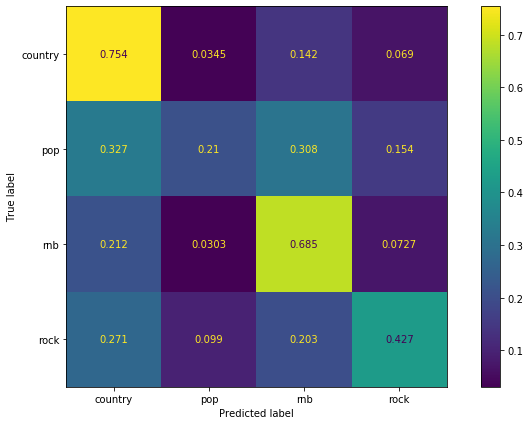

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = MultinomialNB().fit(X_train, y_train.ravel())

plot_confusion_matrix(clf, X_test, y_test, normalize='true', values_format = '0.3g')
fig = plt.gcf()
fig.set_size_inches(12.25, 7)
plt.show()

In [17]:
X = pd.DataFrame(s2[[w for w in words if w not in stopwords.words("english") and w not in least_imp]])
y = pd.DataFrame(s2['genre'])

X = X.to_numpy()
y = y.to_numpy()

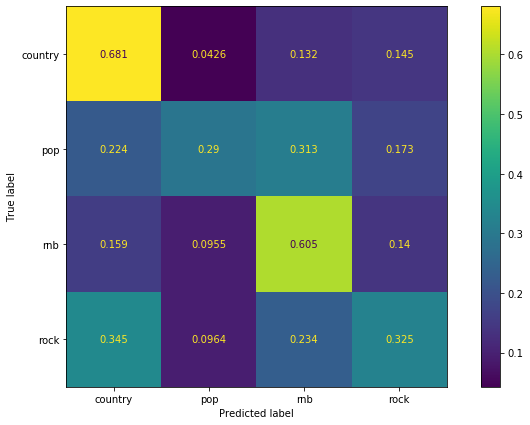

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = MultinomialNB().fit(X_train, y_train.ravel())

plot_confusion_matrix(clf, X_test, y_test, normalize='true', values_format = '0.3g')
fig = plt.gcf()
fig.set_size_inches(12.25, 7)
plt.show()